In [1]:
%run ~/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('pipeline/notebooks', ''))

/Users/maayanlab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
counts = {os.path.basename(x).split('-')[0].replace('kallisto', 'all'): pd.read_table(x, index_col='gene_symbol') for x in glob.glob('./s2-expression.dir/*.txt')}
logcpm = {key: np.log10((value/value.sum())*10**6+1) for key, value in counts.items()}

In [3]:
metadata_dataframe = pd.read_table('./rawdata/metadata/sample_metadata_processed.txt', index_col='sample')
metadata_dataframe['intensity'] = metadata_dataframe['jsqcm'].astype(str)

In [4]:
def run_pca(expression_dataframe, nr_genes=2500):

    # Filter rows
    expression_dataframe = expression_dataframe.loc[expression_dataframe.var(axis=1).sort_values(ascending=False).index[:nr_genes]]

    # Z-score
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        expression_dataframe = expression_dataframe.T.apply(ss.zscore, axis=0).T.dropna()

    # Run PCA
    pca=PCA(n_components=3)
    pca.fit(expression_dataframe)

    # Get Variance
    var_explained = ['PC'+str((i+1))+'('+str(round(e*100, 1))+'% var. explained)' for i, e in enumerate(pca.explained_variance_ratio_)]

    # Dataframe
    pca_dataframe = pd.DataFrame(pca.components_, columns=expression_dataframe.columns, index=['PC{}'.format(x+1) for x in range(len(pca.components_))]).T
    plot_dataframe = pca_dataframe.merge(metadata_dataframe, left_index=True, right_index=True)

    # Return
    return {'dataframe': plot_dataframe, 'var_explained': np.array(var_explained)}

In [5]:
pca = {key: run_pca(value) for key, value in logcpm.items()}

In [6]:
data = 'all'
plot_dataframe = pca[data]['dataframe']
var = pca[data]['var_explained']

KeyError: 'all'

In [ ]:
%%R -i plot_dataframe,var -h 500 -w 800 -r 150
ticks <- seq(3,6)*10^7
ggplot(plot_dataframe, aes(x=PC1, y=PC2, color=cell_line)) +
labs(x=var[1], y=var[2]) +
geom_point() +
theme_classic() +
theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0))

In [13]:
%%R
plot_pca <- function(plot_dataframe, var, cell_line) {
    gp1 <- ggplot(plot_dataframe, aes(x=PC1, y=PC2, color=timepoint)) +
        labs(x=var[1], y=var[2], title=cell_line) +
        geom_point() +
#         scale_fill_manual(values=c('#ffffb2','#fd8d3c','#e31a1c','#fecc5c')) + 
        theme_classic() +
        theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0), plot.title = element_text(hjust = 0.5))
    gp2 <- ggplot(plot_dataframe, aes(x=PC1, y=PC2, color=treatment, shape=intensity)) +
        labs(x=var[1], y=var[2], title=cell_line) +
        geom_point(size=2) +
        scale_color_manual(values=c('black', 'red')) +
        theme_classic() +
        theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0), plot.title = element_text(hjust = 0.5))
    require(gridExtra)
    grid.arrange(gp1, gp2, ncol=2)
}

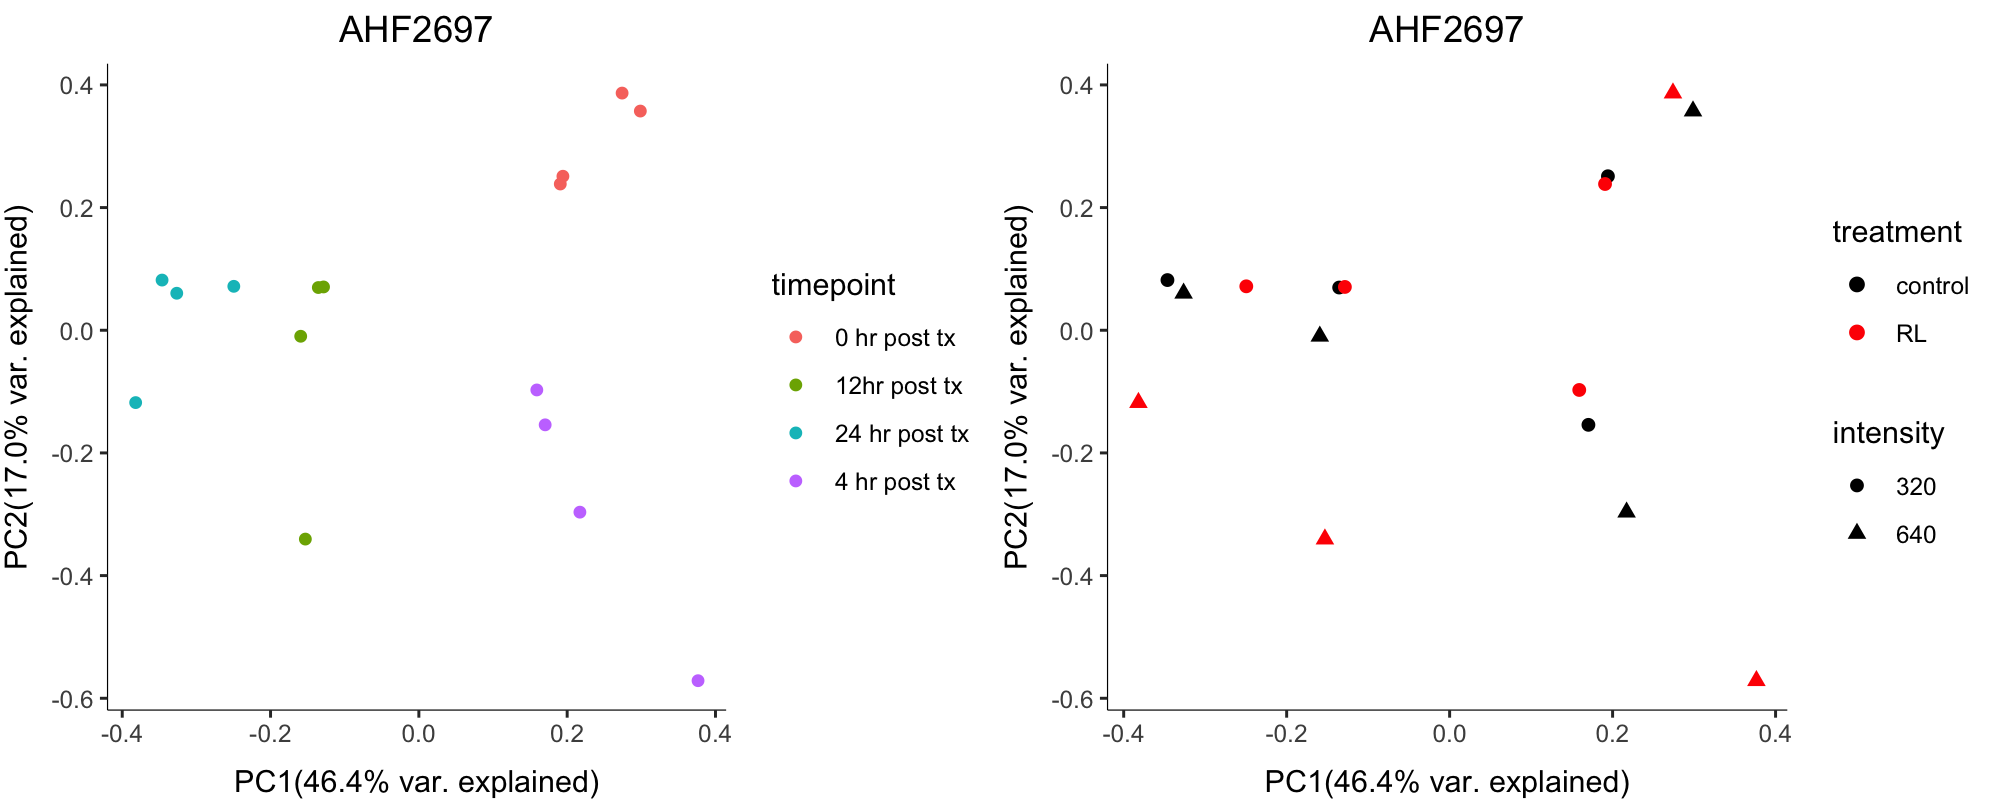

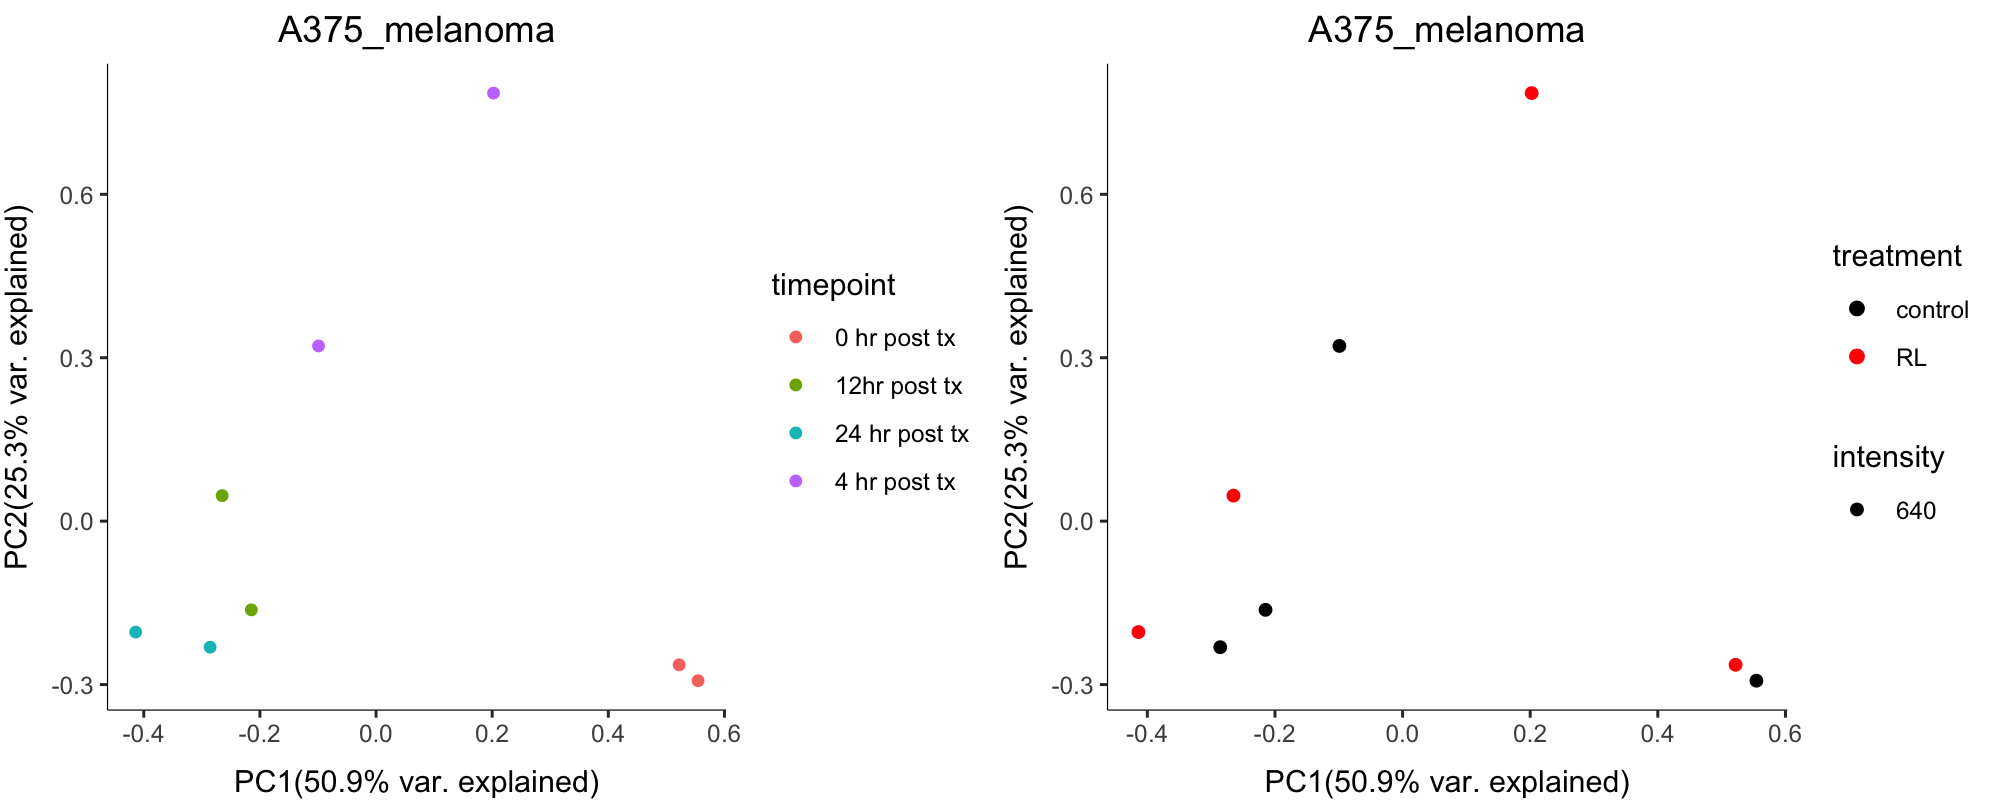

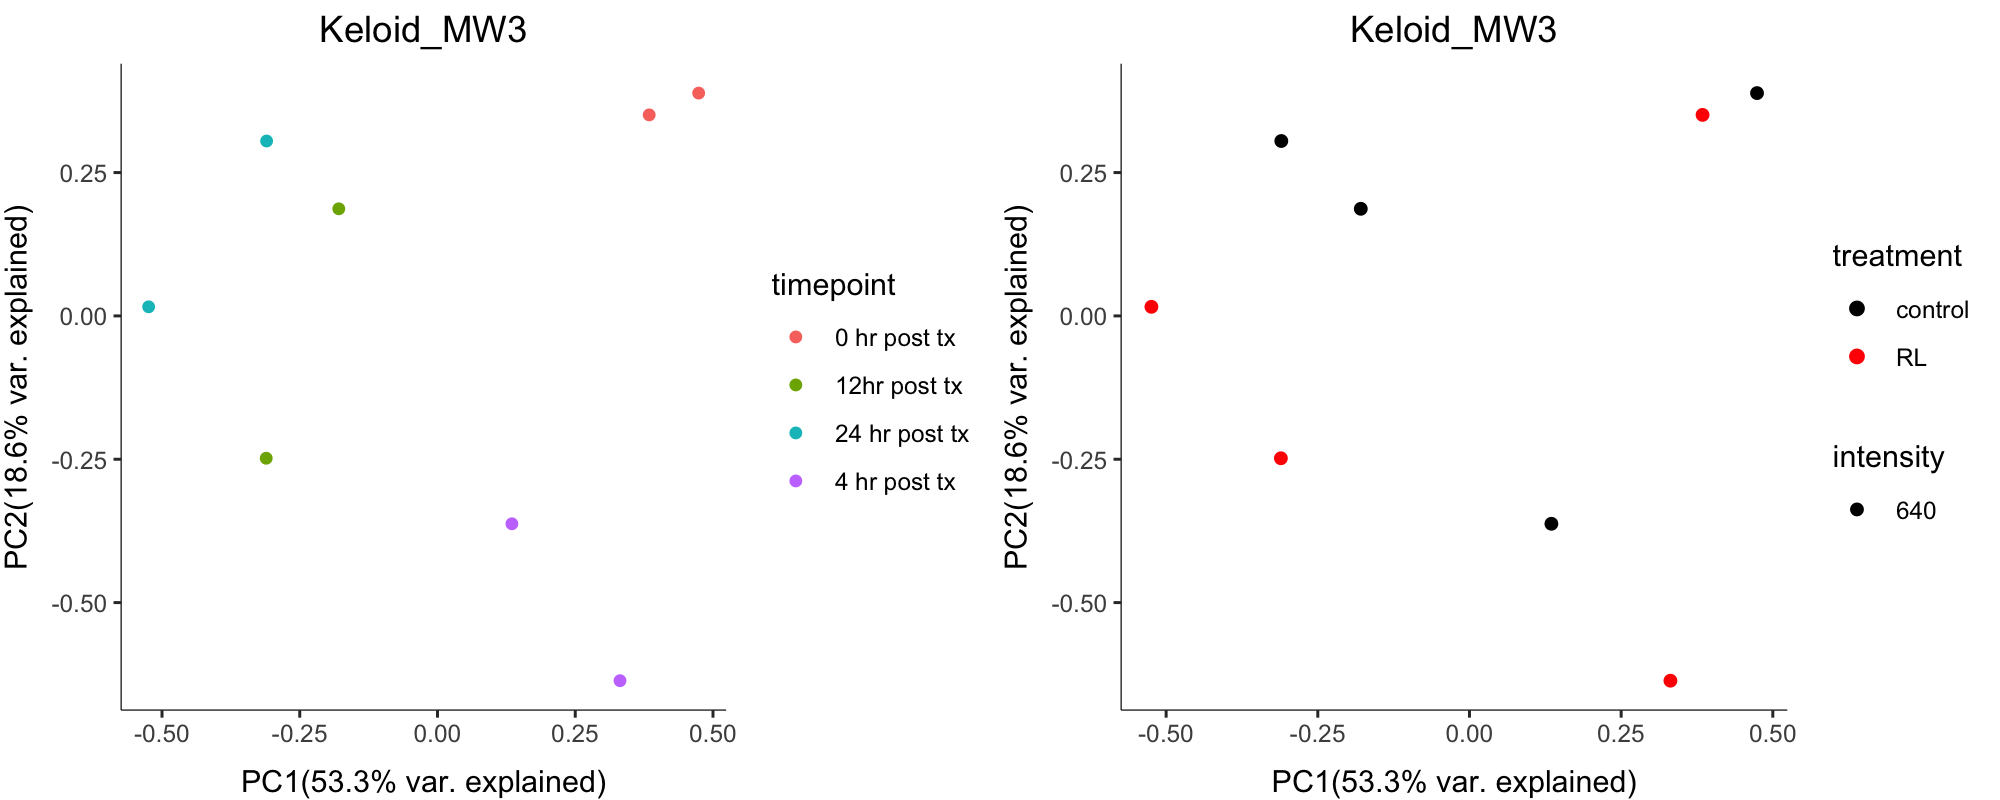

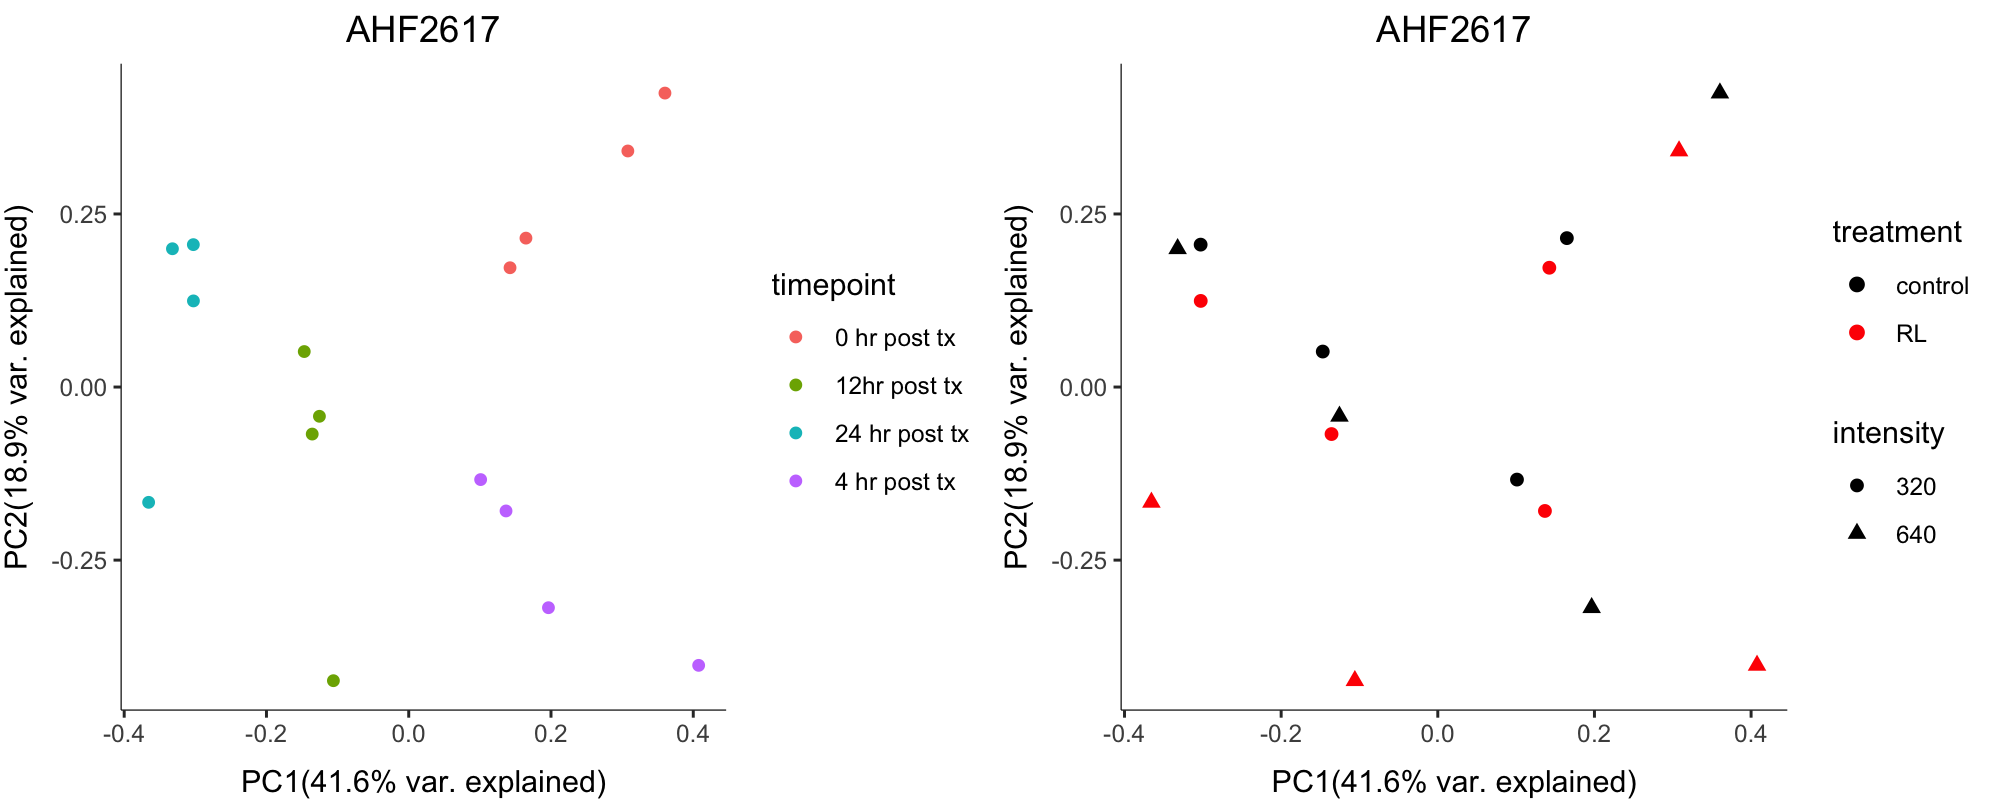

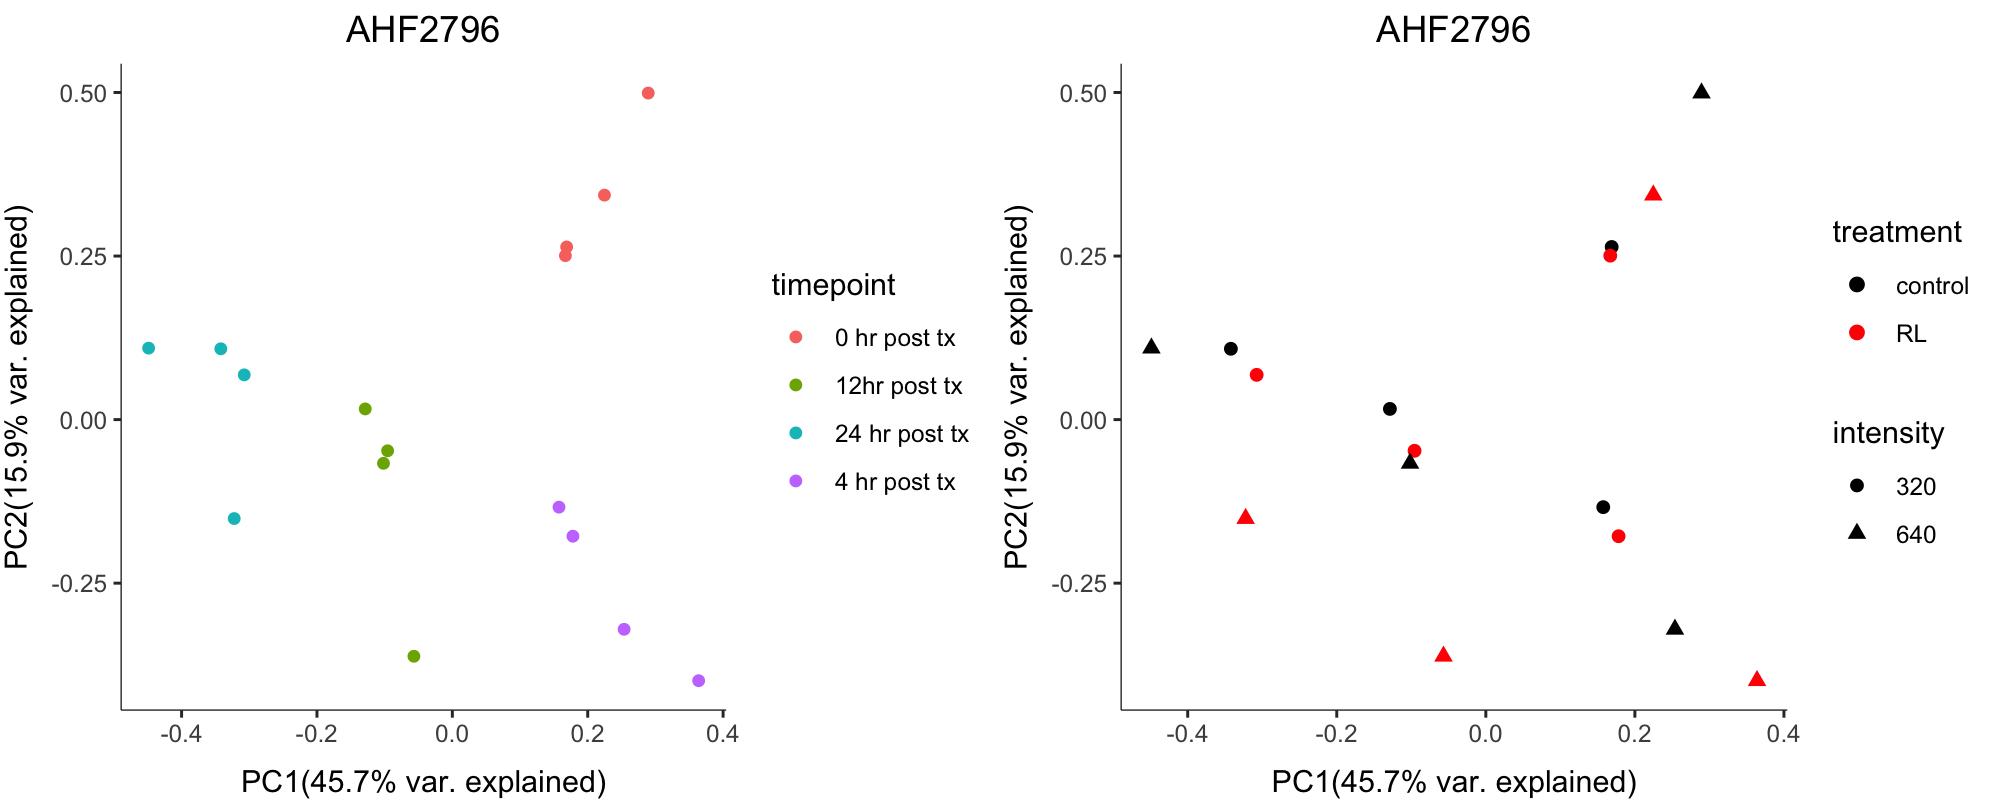

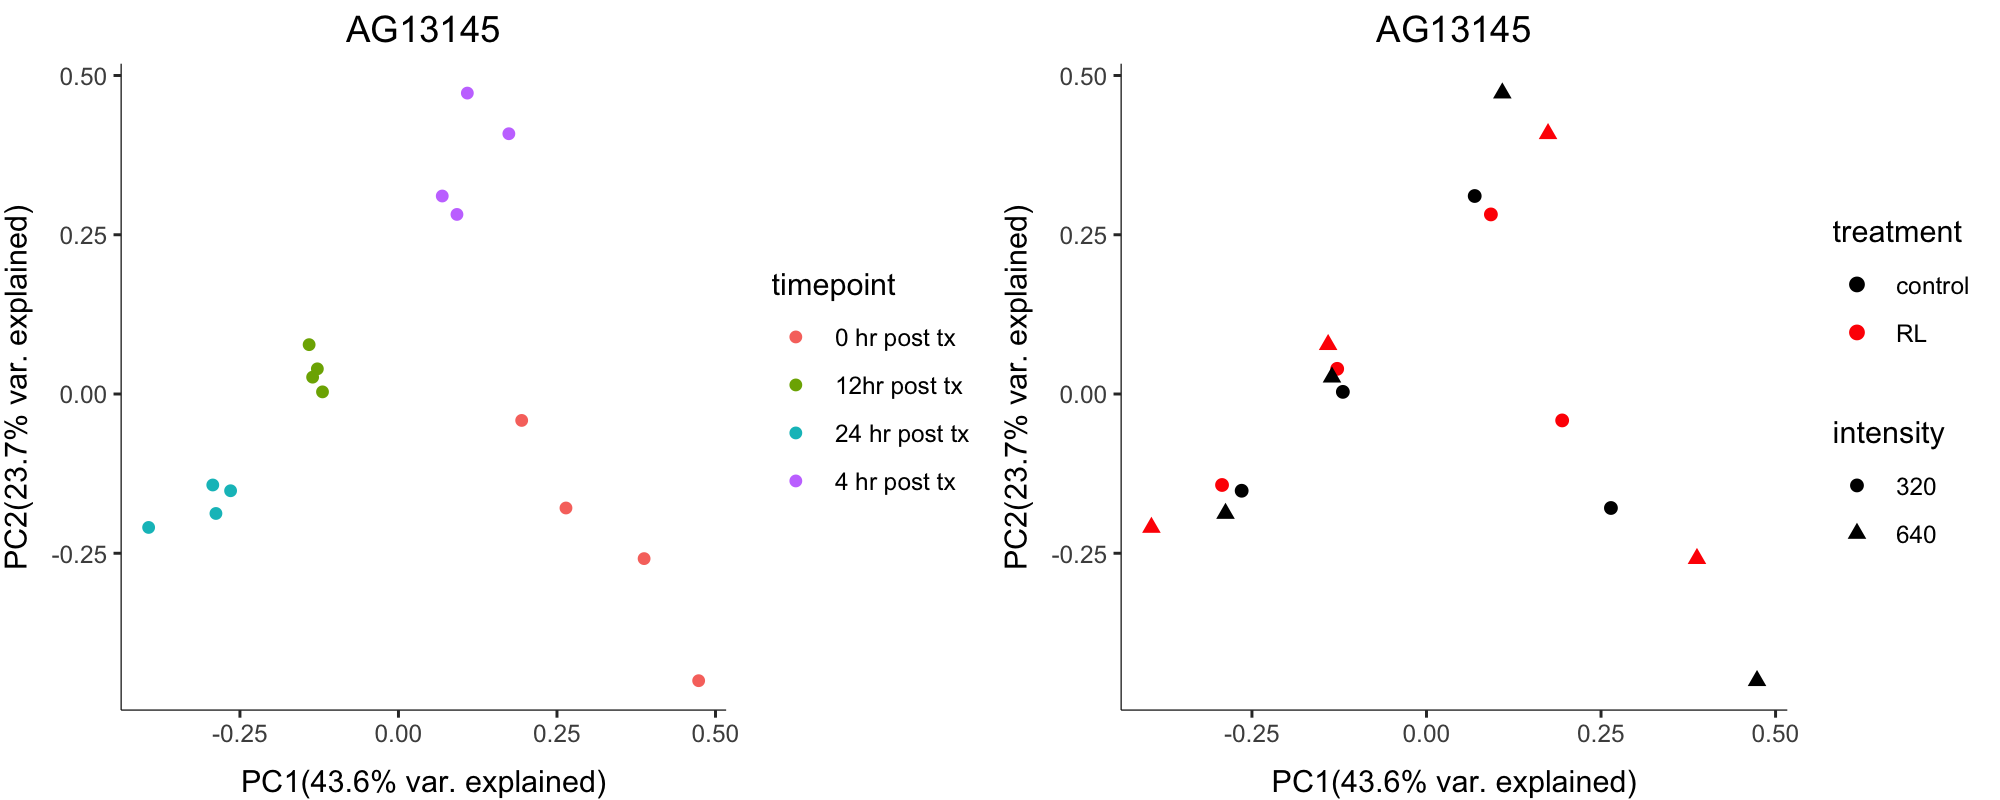

In [14]:
for cell_line, data in pca.items():
    plot_dataframe = data['dataframe']
    var = data['var_explained']
    %R -h 800 -w 2000 -r 200 -i plot_dataframe,var,cell_line plot_pca(plot_dataframe,var,cell_line)